Goal: To demonstrate the neural net architecture for code2seq

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchtext.datasets import AmazonReviewFull

import numpy as np
import matplotlib.pylab as plt

import pickle
import os
import operator

### Dataset

In [2]:
dp_train = AmazonReviewFull(root='../', split='train')
dp_test = AmazonReviewFull(root='../', split='test')

In [3]:
batch_size = 64
dl_train = DataLoader(dp_train, batch_size=batch_size)
dl_test = DataLoader(dp_test, batch_size=batch_size)

In [12]:
y, X = next(iter(dl_train)) #sample one batch of data

In [15]:
print(X[7]) #review
print(y[7]) #rating

Errors, but great story I was a dissapointed to see errors on the back cover, but since I paid for the book I read it anyway. I have to say I love it. I couldn't put it down. I read the whole book in two hours. I say buy it. I say read it. It is sad, but it gives an interesting point of view on church today. We spend too much time looking at the faults of others. I also enjoyed beloved.Sincerly,Jaylynn R
tensor(4)


### Vocabulary

In [24]:
#test processing of single sentence
np.unique(np.concatenate([s.strip().replace(',','').split() for s in X[7].lower().split('.')]), return_counts=True)

(array(['a', 'also', 'an', 'anyway', 'at', 'back', 'beloved', 'book',
        'but', 'buy', 'church', "couldn't", 'cover', 'dissapointed',
        'down', 'enjoyed', 'errors', 'faults', 'for', 'gives', 'great',
        'have', 'hours', 'i', 'in', 'interesting', 'is', 'it', 'looking',
        'love', 'much', 'of', 'on', 'others', 'paid', 'point', 'put', 'r',
        'read', 'sad', 'say', 'see', 'since', 'sincerlyjaylynn', 'spend',
        'story', 'the', 'time', 'to', 'today', 'too', 'two', 'view', 'was',
        'we', 'whole'], dtype='<U15'),
 array([ 1,  1,  1,  1,  1,  1,  1,  2,  3,  1,  1,  1,  1,  1,  1,  1,  2,
         1,  1,  1,  1,  1,  1, 10,  1,  1,  1,  7,  1,  1,  1,  2,  2,  1,
         1,  1,  1,  1,  3,  1,  3,  1,  1,  1,  1,  1,  4,  1,  2,  1,  1,
         1,  1,  1,  1,  1]))

In [25]:
#build dictionary of word counts i.e. word -> occurrence count

def get_counts(dl_train):
    counts_dict = {}
    for y, X_batch in dl_train: #loop over batch
        #get unique words and counts from each sentence
        for X in X_batch: #loop over sentences in batch
            words, counts = np.unique(np.concatenate([s.strip().replace(',','').split() for s in X.lower().split('.')]), return_counts=True)

            for idx, w in enumerate(words):
                if w not in counts_dict:
                    counts_dict[w] = 0

                counts_dict[w] += counts[idx]
    return counts_dict

/home/sanjay/Downloads/venv_pytorch/lib64/python3.9/site-packages/torch/utils/data/datapipes/iter/combining.py:248: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [38]:
if not os.path.exists('train_word_counts.pkl'):
    print('Computing word counts...')
    counts_dict = get_counts(dl_train)
    pickle.dump(counts_dict, open('train_word_counts.pkl','wb'))
else:
    print('Reading pre-computed word counts...')
    counts_dict = pickle.load(open('train_word_counts.pkl','rb'))

Reading pre-computed word counts...


In [42]:
#print entries with decreasing word counts
counts_sorted = sorted(counts_dict.items(), key=operator.itemgetter(1), reverse=True)

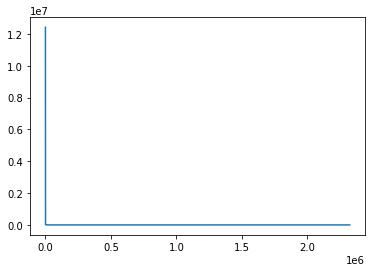

In [43]:
plt.plot([s[1] for s in counts_sorted])

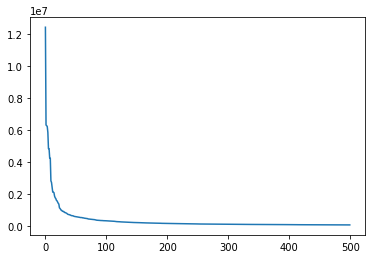

In [45]:
plt.plot([s[1] for s in counts_sorted[0:500]])

In [53]:
len(counts_sorted)

2323521

In [55]:
print('position from top, word, count')
for i in np.power(10, np.arange(6)):
    print(i, counts_sorted[i])

position from top, word, count
1 ('and', 6300311)
10 ('for', 2704868)
100 ('am', 307976)
1000 ('table', 22410)
10000 ('goodwill', 1025)
100000 ('waterfowl', 26)


Out of ~2.3 million words, even the 100,000th word has only a count of 26. Let's truncate our word list here (feel free to choose a smaller threshold for the exercise), and remove all less frequent words i.e. replace with ''.

### Model prototyping

From now on, we will work with just one batch of data or even just one data point i.e. one review. The idea is to put a model architecture together that we expect to be able to predict the ratings. In other words, we want an encoder that will encode a paragraph i.e. a sequence of sentences. There are multiple ways of doing this but we will focus on a model similar to code2seq.

In [57]:
y, X = next(iter(dl_train)) #sample one batch of data

In [ ]:
for s in X[idx].lower().replace(',', '').split('.'): #loop over sentences
    sent = []
    for w in s.split():
        if w in valid_words:
            

In [71]:
[t for s in X[7].lower().replace(',', '').split('.') for t in s.split()]

['errors',
 'but',
 'great',
 'story',
 'i',
 'was',
 'a',
 'dissapointed',
 'to',
 'see',
 'errors',
 'on',
 'the',
 'back',
 'cover',
 'but',
 'since',
 'i',
 'paid',
 'for',
 'the',
 'book',
 'i',
 'read',
 'it',
 'anyway',
 'i',
 'have',
 'to',
 'say',
 'i',
 'love',
 'it',
 'i',
 "couldn't",
 'put',
 'it',
 'down',
 'i',
 'read',
 'the',
 'whole',
 'book',
 'in',
 'two',
 'hours',
 'i',
 'say',
 'buy',
 'it',
 'i',
 'say',
 'read',
 'it',
 'it',
 'is',
 'sad',
 'but',
 'it',
 'gives',
 'an',
 'interesting',
 'point',
 'of',
 'view',
 'on',
 'church',
 'today',
 'we',
 'spend',
 'too',
 'much',
 'time',
 'looking',
 'at',
 'the',
 'faults',
 'of',
 'others',
 'i',
 'also',
 'enjoyed',
 'beloved',
 'sincerlyjaylynn',
 'r']

In [64]:
[s.replace(',', '') for s in X[idx].lower().split('.')]

['errors but great story i was a dissapointed to see errors on the back cover but since i paid for the book i read it anyway',
 ' i have to say i love it',
 " i couldn't put it down",
 ' i read the whole book in two hours',
 ' i say buy it',
 ' i say read it',
 ' it is sad but it gives an interesting point of view on church today',
 ' we spend too much time looking at the faults of others',
 ' i also enjoyed beloved',
 'sincerlyjaylynn r']

In [60]:
idx = 7

[s.strip().replace(',','').split() for s in X[idx].lower().split('.') if ]

[['errors',
  'but',
  'great',
  'story',
  'i',
  'was',
  'a',
  'dissapointed',
  'to',
  'see',
  'errors',
  'on',
  'the',
  'back',
  'cover',
  'but',
  'since',
  'i',
  'paid',
  'for',
  'the',
  'book',
  'i',
  'read',
  'it',
  'anyway'],
 ['i', 'have', 'to', 'say', 'i', 'love', 'it'],
 ['i', "couldn't", 'put', 'it', 'down'],
 ['i', 'read', 'the', 'whole', 'book', 'in', 'two', 'hours'],
 ['i', 'say', 'buy', 'it'],
 ['i', 'say', 'read', 'it'],
 ['it',
  'is',
  'sad',
  'but',
  'it',
  'gives',
  'an',
  'interesting',
  'point',
  'of',
  'view',
  'on',
  'church',
  'today'],
 ['we',
  'spend',
  'too',
  'much',
  'time',
  'looking',
  'at',
  'the',
  'faults',
  'of',
  'others'],
 ['i', 'also', 'enjoyed', 'beloved'],
 ['sincerlyjaylynn', 'r']]

### Model prototyping

In [18]:
[s.strip() for s in X[7].lower()a.split('.')]

['errors, but great story i was a dissapointed to see errors on the back cover, but since i paid for the book i read it anyway',
 'i have to say i love it',
 "i couldn't put it down",
 'i read the whole book in two hours',
 'i say buy it',
 'i say read it',
 'it is sad, but it gives an interesting point of view on church today',
 'we spend too much time looking at the faults of others',
 'i also enjoyed beloved',
 'sincerly,jaylynn r']